In [1]:
from ipywidgets import widgets, interact, fixed
from IPython.display import display
%matplotlib inline
import seaborn as sbn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from IPython.core.pylabtools import figsize
import scipy
import scipy.interpolate
from contextlib import redirect_stdout
from CoolProp import CoolProp
figsize(12, 10)
sbn.set_context("talk", font_scale=1)

In [2]:
pip install coolprop

Note: you may need to restart the kernel to use updated packages.


# Defining the function for the sensetivity analysis

In [2]:
@interact
def BV_Diff_O2(L=0.01, tfinal=21600, sat=0.15, i0=2.55, T=298., OV=-0.075):
    alpha = 2
    F = 96485
    R = 8.314
    #current = np.array([0])
    O2_limit = 10**-20
    CO20 = 0.26  # mol/m3
    COH0 = (10**-4)  # mol/m3
    concO2 = np.array([0.26])
    concOH = np.array([10**-4])
    BC1 = CO20  # Boundary condition 1, in the bulk

    # Diffusion
    N = 20  # number of points to discretize
    X = np.linspace(0, L, N)  # position along the rod
    h = L / (N - 1)  # discretization spacing

    D = 2.9 * 10**-9  # Diffusivity

    Ntsteps = tfinal
    dt = tfinal / (Ntsteps)
    t = np.arange(0, tfinal, dt)
    alpha = D * dt / h**2

    C = np.zeros(X.shape)
    C[0] = BC1

    #current = np.array([])

    for j in range(tfinal):
        N = np.zeros(C.shape)
        N[0] = BC1
        N[1:-1] = alpha * C[2:] + (1 - 2 * alpha) * C[1:-1] + alpha * C[0:-2]
        if N[-2] < sat:
            N[-1] = N[-2]
            #current = np.append(current, 0)
            concOH = np.append(concOH, concOH[-1])
            concO2 = np.append(concO2, N[-1])
        else:
            iloc = i0 * ((concOH[j] * np.exp((alpha * F * OV) / (R * T))) - (N[-2] * np.exp((-(alpha) * F * OV) / (R * T))))
            RO2 = -1 * abs(iloc) / (F * 4)
            N[-1] = (RO2 * h) + N[-2]
            new_concO2 = N[-1]
            concO2 = np.append(concO2, new_concO2)

            ROH = 4 * abs(iloc) / (F * 4)
            new_concOH = (ROH * h) + concOH[j]
            concOH = np.append(concOH, new_concOH)

            newCurrent = iloc * 0.0104
            #current = np.append(current, newCurrent)

        C[:] = N

    return C[-1]



interactive(children=(FloatSlider(value=0.01, description='L', max=0.03, min=-0.01), IntSlider(value=21600, de…

Let's see the interaction for pH change as well:

In [3]:
@interact
def BV_Diff_pH( L = 0.01, #...
                  tfinal = 21600, # ...
                  sat = 0.15,
                  i0 = 2.55,
                  T = 298., # ...
                  OV = -0.075, # ...
                 ):
    alpha = 2#...
    F = 96485#...
    R = 8.314#...
    #current = np.array([0])
    O2_limit = 10**-20
#     OV = -0.075#
    CO20 = 0.26 #mol/m3
    COH0 = (10**-4)#mol/m3
    concO2 = np.array([0.26])
    concOH = np.array([10**-4])
    BC1 = CO20 #Boundary condition 1, in the bulk

    #   Diffusion
    N = 20  # number of points to discretize
    #L = 0.01
    X = np.linspace(0, L, N)  # position along the rod
    h = L / (N - 1)  # discretization spacing


    D = 2.9*10**-9  # Diffusivity

    #tfinal = 54000 #15 hours
    Ntsteps = tfinal
    dt = tfinal / (Ntsteps)
    t = np.arange(0, tfinal, dt)
    alpha = D * dt / h**2


    # initial condition at t = 0
    C = np.zeros(X.shape)
    C[0] = BC1

    #current = np.array([])

    for j in range(tfinal):
        N = np.zeros(C.shape)
        N[0] = BC1
        N[1:-1] = alpha * C[2:] + (1 - 2 * alpha) * C[1:-1] + alpha * C[0:-2]
        if N[-2] < sat: #to give it some time until the solution gets to a degree of saturation
            N[-1] = N[-2]  # derivative boundary condition flux = 0
            #current = np.append(current, 0)
            concOH = np.append(concOH, concOH[0])
            concO2 = np.append(concO2, N[-1])

        else: #after the solution is saturated with O2
            #print('Saturated')
            iloc = i0*((concOH[j]*np.exp((alpha*F*OV)/(R*T))) - (N[-2]*np.exp((-(alpha)*F*OV)/(R*T)))) #Current density

            RO2 = -1*abs(iloc)/(F*4) #Rate of O2 consumption or flux at the surface 

            N[-1] = (RO2*h) + N[-2]  # derivative boundary condition flux = RO2, BC2
            new_concO2 = N[-1]
            concO2 = np.append(concO2, new_concO2)

            ROH = 4*abs(iloc)/(F*4) #Rate of OH production

            new_concOH = (ROH*h) + concOH[j]

            concOH = np.append(concOH, new_concOH)

            newCurrent = iloc*0.0104

            #current = np.append(current, newCurrent)

        C[:] = N #Crucial for the loop
     
    pH = 14 + np.log(concOH[tfinal] )
    pH0=14+np.log(COH0)
    pHChange=pH-pH0
    return  pHChange

interactive(children=(FloatSlider(value=0.01, description='L', max=0.03, min=-0.01), IntSlider(value=21600, de…

In [4]:
@interact
def BV_Diff_Current( L = 0.01, #...
                  tfinal = 21600, # ...
                  sat = 0.15,
                  i0 = 2.55,
                  T = 298., # ...
                  OV = -0.075, # ...
                 ):
    alpha = 2#...
    F = 96485#...
    R = 8.314#...
    current = np.array([0])
    O2_limit = 10**-20
#     OV = -0.075#
    CO20 = 0.26 #mol/m3
    COH0 = (10**-4)#mol/m3
    concO2 = np.array([0.26])
    concOH = np.array([10**-4])
    BC1 = CO20 #Boundary condition 1, in the bulk

    #   Diffusion
    N = 20  # number of points to discretize
    #L = 0.01
    X = np.linspace(0, L, N)  # position along the rod
    h = L / (N - 1)  # discretization spacing


    D = 2.9*10**-9  # Diffusivity

    #tfinal = 54000 #15 hours
    Ntsteps = tfinal
    dt = tfinal / (Ntsteps)
    t = np.arange(0, tfinal, dt)
    alpha = D * dt / h**2


    # initial condition at t = 0
    C = np.zeros(X.shape)
    C[0] = BC1

    current = np.array([])

    for j in range(tfinal):
        N = np.zeros(C.shape)
        N[0] = BC1
        N[1:-1] = alpha * C[2:] + (1 - 2 * alpha) * C[1:-1] + alpha * C[0:-2]
        if N[-2] < 0.15: #to give it some time until the solution gets to a degree of saturation
            N[-1] = N[-2]  # derivative boundary condition flux = 0
            current = np.append(current, 0)
            concOH = np.append(concOH, concOH[0])
            concO2 = np.append(concO2, N[-1])

        else: #after the solution is saturated with O2
            #print('Saturated')
            iloc = i0*((concOH[j]*np.exp((alpha*F*OV)/(R*T))) - (N[-2]*np.exp((-(alpha)*F*OV)/(R*T)))) #Current density

            RO2 = -1*abs(iloc)/(F*4) #Rate of O2 consumption or flux at the surface 

            N[-1] = (RO2*h) + N[-2]  # derivative boundary condition flux = RO2, BC2
            new_concO2 = N[-1]
            concO2 = np.append(concO2, new_concO2)

            ROH = 4*abs(iloc)/(F*4) #Rate of OH production

            new_concOH = (ROH*h) + concOH[j]

            concOH = np.append(concOH, new_concOH)

            newCurrent = iloc*0.0104

            current = np.append(current, newCurrent)

        C[:] = N #Crucial for the loop
     
    
    return  current[-1]

interactive(children=(FloatSlider(value=0.01, description='L', max=0.03, min=-0.01), IntSlider(value=21600, de…

In [27]:
tfinal = 21600
Ntsteps = 21600  # Choose an appropriate number of steps
dt = tfinal / (Ntsteps)  # Calculate the correct time step
t = np.arange(0, tfinal, dt)
print(t)


[0.0000e+00 1.0000e+00 2.0000e+00 ... 2.1597e+04 2.1598e+04 2.1599e+04]


In [20]:
def BV_Diff_O2_new(L=0.01, tfinal=np.array([10800, 10800]), sat=np.array([0.2, 0.1]), i0=2.55, T=298., OV=-0.075):
    alpha = 2
    F = 96485
    R = 8.314
    O2_limit = 1e-20
    CO20 = 0.26  # mol/m3
    COH0 = 1e-4  # mol/m3
    concO2 = np.array([0.26])
    concOH = np.array([1e-4])
    BC1 = CO20  # Boundary condition 1, in the bulk

    # Diffusion
    N = 20  # number of points to discretize
    X = np.linspace(0, L, N)  # position along the rod
    h = L / (N - 1)  # discretization spacing

    D = 2.9 * 1e-9  # Diffusivity
    C = np.zeros(X.shape)
    C[0] = BC1
    L=[]
    g=[]
    q=[]
    for p in range(len(sat)):
        s1 = sat[p]
        for k in range(len(tfinal)):
            t1 = tfinal[k]
            Ntsteps = t1
            dt = t1 / Ntsteps
            t = np.arange(0, t1, dt)
            alpha = D * dt / h**2

            for j in range(len(t)):
                N = np.zeros(C.shape)
                N[0] = BC1
                N[1:-1] = alpha * C[2:] + (1 - 2 * alpha) * C[1:-1] + alpha * C[0:-2]

                if np.any(N[-2] < s1):
                    N[-1] = N[-2]
                    concOH = np.append(concOH, concOH[-1])
                    concO2 = np.append(concO2, N[-1])
                else:
                    iloc = i0 * ((concOH[-1] * np.exp((alpha * F * OV) / (R * T))) - (N[-2] * np.exp((-alpha * F * OV) / (R * T))))
                    RO2 = -abs(iloc) / (F * 4)
                    N[-1] = (RO2 * h) + N[-2]
                    concO2 = np.append(concO2, N[-1])

                    ROH = 4 * abs(iloc) / (F * 4)
                    concOH = np.append(concOH, (ROH * h) + concOH[-1])

                C[:] = N
            L = np.append(L, N[-1])
        g=np.append(g, L)
    q=np.append(q, g)
    return q[-1]



In [2]:
def FD_Diff(L, tfinal, sat, i0,T,OV):
    alpha = 2
    F = 96485
    R = 8.314
    O2_limit = 1e-20
    CO20 = 0.26  # mol/m3
    COH0 = 1e-4  # mol/m3
    concO2 = np.array([0.26])
    concOH = np.array([1e-4])
    BC1 = CO20  # Boundary condition 1, in the bulk

    # Diffusion
    N = 20  # number of points to discretize
    X = np.linspace(0, L, N)  # position along the rod
    h = L / (N - 1)  # discretization spacing

    D = 2.9 * 1e-9  # Diffusivity
    Ntsteps = tfinal
    dt = tfinal / Ntsteps
    t = np.arange(0, tfinal, dt)
    alpha = D * dt / h**2
    C = np.zeros((t.shape[0],X.shape[0]))
    K= np.zeros((t.shape[0],X.shape[0]))
    pH0=14+np.log(COH0)
    pHChange = np.array([0])
    C[:,0] = BC1
    K[:,0] = BC1
    for j in range(1,t.shape[0]):
        N = np.zeros(X.shape)
        N[0] = BC1
        N[1:-1] = alpha * C[j-1,2:] +(1-2*alpha)* C[j-1,1:-1] + alpha * C[j-1,0:-2]


        if N[-2] < sat:
            N[-1] = N[-2]
            concOH = np.append(concOH, concOH[-1])
            concO2 = np.append(concO2, N[-1])
        else:
            iloc = i0 * ((concOH[-1] * np.exp((alpha * F * OV) / (R * T))) - (N[-2] * np.exp((-alpha * F * OV) / (R * T))))
            RO2 = -abs(iloc) / (F * 4)
            N[-1] = (RO2 * h) + N[-2]
            concO2 = np.append(concO2, N[-1])

            ROH = 4 * abs(iloc) / (F * 4)
            concOH = np.append(concOH, (ROH * h) + concOH[-1])
        pH = 14 + np.log(concOH[-1])
        pH0=14+np.log(COH0)
        Change=pH-pH0
        pHChange = np.append(pHChange, Change)
        C[j,:]= N
        K[j,:]= N
    return pHChange


In [14]:
a=FD_Diff(L=0.01,tfinal=54000,sat=0.15,i0=1.55,T=283,OV=-1.5)
print(a.shape)
print(a)
# print(a[-1,:].shape)
#print(a[-1,:])


(54000,)
[0.         6.90775528 6.90775528 ... 7.79424147 7.79425834 7.79427521]


In [3]:
def BV_Diff_Sens(L, tfinal, sat, i0, T, OV):
#     G=[]
#     Q=[]
#     P=[]
#     F=[]
#     W=[]
    A=[]
    for i in range(len(L)):
        l1 = L[i]
        t1 = tfinal[i]
        s1 = sat[i]
        i01 = i0[i]
        T1 = T[i]
        OV1 = OV[i]
    
        Cst = FD_Diff(l1,t1,s1,i01,T1,OV1)
        A=np.append(A, Cst[-1])
                        #W=np.append(W, A[-1])
                    #F = np.append(F, W[-1])
                #P=np.append(P, F[-1])
            #Q=np.append(F, P[-1])
        #G=np.append(G, Q[-1])
    
    return A



In [5]:
b=BV_Diff_Sens(L=np.array([0.01, 0.02]), tfinal=np.array([54000, 54000]), sat=np.array([0.15,0.15]), i0=np.array([1.55, 2.14]), T=np.array([283, 313]), OV=np.array([-1.5, -0.096]))
print(b)



[0.88651993 0.        ]


# Sensitivity Analysis

In [4]:
from SALib.sample import morris as ms
from SALib.analyze import morris as ma
from SALib.plotting import morris as mp

### Define a problem file

In [5]:
morris_problem = {
    # There are six variables
    'num_vars': 6,
    # These are their names
    'names': ['L', 'tfinal', 'sat', 'i0', 'T', 'OV'],
    # These are their plausible ranges over which we'll move the variables
    'bounds': [[0.005, 0.05], # 'Double layer', 'm'
               [21600, 54000], # 'time duration','sec'
               [0.1, 0.2], # saturation degree', 'mol/m3'z
               [1.55, 3.55], #'exchange current density', 'A'
               [283, 313], # 'Temperature', 'K'
               [-0.1, -0.02], # 'over potential', 'v''
              ],
    # I don't want to group any of these variables together
     'groups': None
    }

In [6]:
morris_problem

{'num_vars': 6,
 'names': ['L', 'tfinal', 'sat', 'i0', 'T', 'OV'],
 'bounds': [[0.005, 0.05],
  [21600, 54000],
  [0.1, 0.2],
  [1.55, 3.55],
  [283, 313],
  [-0.1, -0.02]],
 'groups': None}

# Generate a Sample

In [7]:
num_levels = 2
trajectories = int(1e01)
sample = ms.sample(morris_problem, trajectories, num_levels=num_levels)
sample.shape

(70, 6)

In [12]:
print(sample.T.shape)
#print(sample.T)


(6, 70)


### Factor Prioritisation

We'll run a sensitivity analysis of the power module to see which is the most influential parameter.

The results parameters are called **mu**, **sigma** and **mu_star**.

* **Mu** is the mean effect caused by the input parameter being moved over its range.
* **Sigma** is the standard deviation of the mean effect.
* **Mu_star** is the mean absolute effect.

In [8]:
# Run the sample through the power model
output = (BV_Diff_Sens(*sample.T))
print(output.shape)
print(output)

(70,)
[0.90849163 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.36844606 0.90849163 0.         0.         0.
 0.         0.         0.         0.         0.         0.1588118
 0.33231223 0.80417377 0.8268614  0.82871647 0.         0.
 0.         0.         0.15929624 0.43243606 0.44691279 0.
 0.87476585 0.47660635 0.48288222 0.43243606 0.15929624 0.17827946
 0.         0.         0.         0.         0.         0.
 0.37416348 0.         0.         0.         0.4084302  0.41398316
 0.20206006 0.49866608 0.87476585 0.80417377 0.80599571 0.33324482
 0.         0.         0.         0.         0.         0.
 0.1807654  0.15929624 0.1588118  0.33231223]


In [9]:
# Store the results for plotting of the analysis
Si = ma.analyze(morris_problem, 
                sample, 
                output, 
                print_to_console=False, 
                num_levels=num_levels)
print("{:20s} {:>7s} {:>7s} {:>7s}".format("Name", "mu", "mu_star", "sigma"))
for name, s1, st, mean in zip(morris_problem['names'], Si['mu'], Si['mu_star'], Si['sigma']):
    print("{:20s} {:=7.2f} {:=7.2f} {:=7.2f}".format(name, s1, st, mean))

Name                      mu mu_star   sigma
L                    -  0.47    0.47    0.31
tfinal                  0.18    0.18    0.20
sat                  -  0.01    0.01    0.01
i0                      0.10    0.10    0.14
T                    -  0.00    0.00    0.00
OV                   -  0.01    0.01    0.03


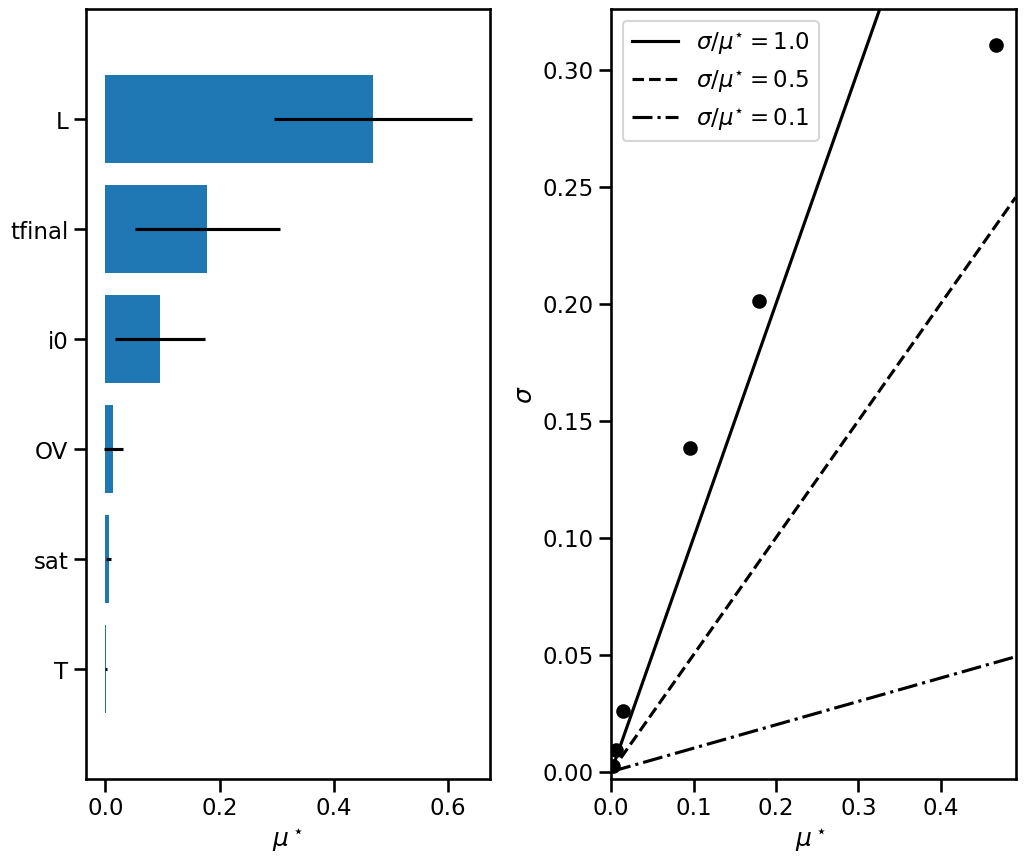

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2)
mp.horizontal_bar_plot(ax1, Si) #  param_dict={}
mp.covariance_plot(ax2, Si, {})
plt.subplots_adjust(wspace=0.3)